<a href="https://colab.research.google.com/github/ReJackTion/cat-dog-image-classification/blob/main/Cat_Dog_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore') #ignore warning to imporve readability

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle #make a new folder
!cp /content/kaggle.json ~/.kaggle/ #copy file to that folder
!chmod 600 ~/.kaggle/kaggle.json #to allow read and write the file

In [ ]:
!kaggle datasets download -d erkamk/cat-and-dog-images-dataset

In [ ]:
!unzip cat-and-dog-images-dataset.zip

# Create File DataFrame

In [3]:
image_dir = Path('/content/Dog and Cat .png')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,/content/Dog and Cat .png/Cat/t21.png,Cat
1,/content/Dog and Cat .png/Cat/t11.png,Cat
2,/content/Dog and Cat .png/Cat/t2.png,Cat
3,/content/Dog and Cat .png/Cat/306.png,Cat
4,/content/Dog and Cat .png/Cat/343.png,Cat
...,...,...
994,/content/Dog and Cat .png/Dog/d240.png,Dog
995,/content/Dog and Cat .png/Dog/d114.png,Dog
996,/content/Dog and Cat .png/Dog/g62.png,Dog
997,/content/Dog and Cat .png/Dog/d13.png,Dog


In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=42)

# Load Image Data

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# Model Building

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 222, 222, 16)      448       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 111, 111, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 109, 109, 32)      4640      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 54, 54, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 52, 52, 64)        18496     
_________________________________________________________________
maxpool3 (MaxPooling2D)      (None, 26, 26, 64)        0     

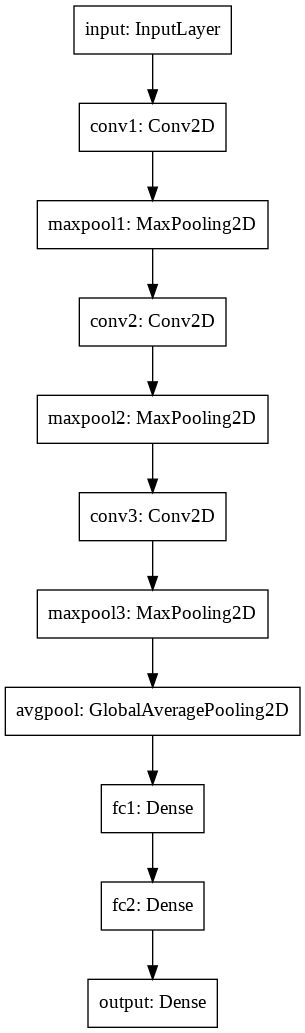

In [10]:
inputs = tf.keras.Input(shape=(224, 224, 3), name='input')

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', name='conv1')(inputs)
maxpool1 = tf.keras.layers.MaxPool2D(name='maxpool1')(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='conv2')(maxpool1)
maxpool2 = tf.keras.layers.MaxPool2D(name='maxpool2')(conv2)

conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv3')(maxpool2)
maxpool3 = tf.keras.layers.MaxPool2D(name='maxpool3')(conv3)

avgpool = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(maxpool3)

fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')(avgpool)
fc2 = tf.keras.layers.Dense(128, activation='relu', name='fc2')(fc1)

outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(fc2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


print(model.summary())
tf.keras.utils.plot_model(model)

# Model Training

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 13s 683ms/step - loss: 0.6042 - accuracy: 0.6821 - val_loss: 0.6217 - val_accuracy: 0.6547
Epoch 2/100
18/18 [==============================] - 11s 638ms/step - loss: 0.6089 - accuracy: 0.6571 - val_loss: 0.5972 - val_accuracy: 0.6835
Epoch 3/100
18/18 [==============================] - 11s 634ms/step - loss: 0.5941 - accuracy: 0.7000 - val_loss: 0.6370 - val_accuracy: 0.6403
Epoch 4/100
18/18 [==============================] - 11s 639ms/step - loss: 0.5975 - accuracy: 0.6893 - val_loss: 0.6089 - val_accuracy: 0.6475
Epoch 5/100
18/18 [==============================] - 11s 644ms/step - loss: 0.5928 - accuracy: 0.6893 - val_loss: 0.6096 - val_accuracy: 0.6619
Epoch 6/100
18/18 [==============================] - 11s 642ms/step - loss: 0.5747 - accuracy: 0.7107 - val_loss: 0.6069 - val_accuracy: 0.6691
Epoch 7/100
18/18 [==============================] - 11s 640ms/step - loss: 0.5811 - accuracy: 0.7125 - val_loss: 0.6192 - val_accuracy:

# Model Evaluation

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.67737
Test Accuracy: 61.00%


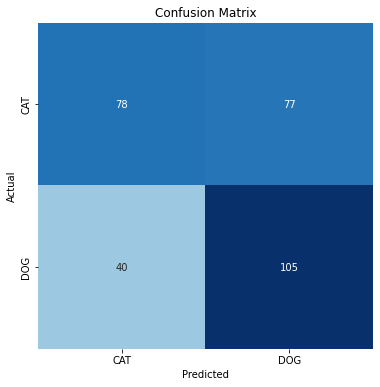

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.66      0.50      0.57       155
         DOG       0.58      0.72      0.64       145

    accuracy                           0.61       300
   macro avg       0.62      0.61      0.61       300
weighted avg       0.62      0.61      0.61       300



In [22]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Save and Load Model

In [23]:
model.save_weights('saved_model/')

In [24]:
model.load_weights('saved_model/')